In [22]:
import numpy as np

data = np.load('../Effect_Att/Data/len_96/False/s13/data.npy')
label = np.load('../Effect_Att/Data/len_96/False/s13/label.npy')

print(data.shape, label.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../Effect_Att/Data/len_96/False/s13/data.npy'

In [5]:
import os
import numpy as np

# 定义数据集的路径
base_path = "../Effect_Att/Data/len_96/False"

# 初始化空列表，用于存储数据和标签
data_list = []
label_list = []

# 遍历文件夹
for i in range(1, 33):  # 从 01 到 32
    folder_name = f"s{i:02d}"  # 格式化为两位数字，前面补零
    folder_path = os.path.join(base_path, folder_name)
    
    data_file = os.path.join(folder_path, "data.npy")
    label_file = os.path.join(folder_path, "label.npy")
    
    # 检查文件是否存在
    if os.path.exists(data_file) and os.path.exists(label_file):
        data = np.load(data_file)
        label = np.load(label_file)
        
        data_list.append(data)
        label_list.append(label)
    else:
        print(f"文件 {data_file} 或 {label_file} 不存在")

# 将列表中的数据和标签沿第0维度拼接在一起
all_data = np.concatenate(data_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

# 打印拼接后的形状
print(f"All data shape: {all_data.shape}")
print(f"All labels shape: {all_labels.shape}")


All data shape: (102400, 32, 4, 96)
All labels shape: (102400,)


In [8]:
np.save("../Effect_Att/Data/len_96/False/all/label.npy", all_labels)

# 可视化第二层GAT后的数据


In [2]:
import torch
i = 0 
attn_weight = torch.load(f'./vis_data/attn_weight_{i}.pt')
edge_index = torch.load(f'./vis_data/edge_index_{i}.pt')
label = torch.load(f'./vis_data/labels_0.pt')

In [24]:
label

tensor([1], device='cuda:1')

In [25]:
label = torch.load(f'./vis_data/labels_6.pt')
label

tensor([2], device='cuda:1')

/tmp/ipykernel_53310/4037369519.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Node Connection Strength')


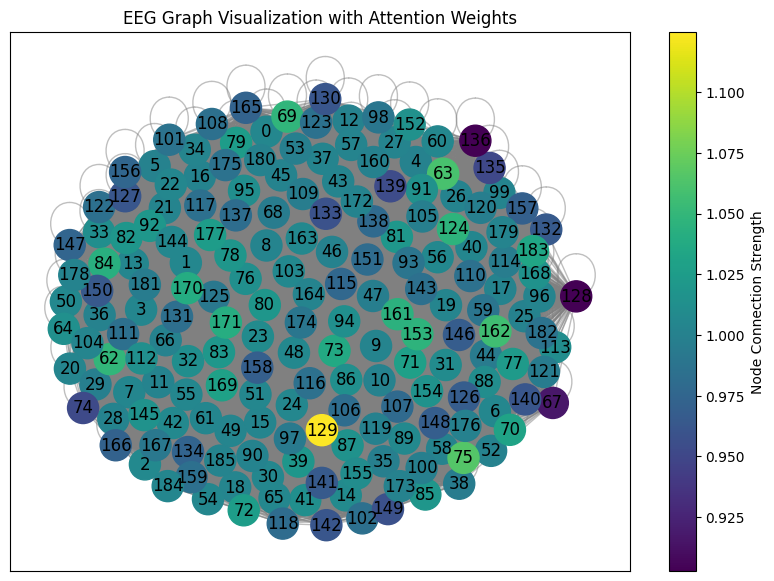

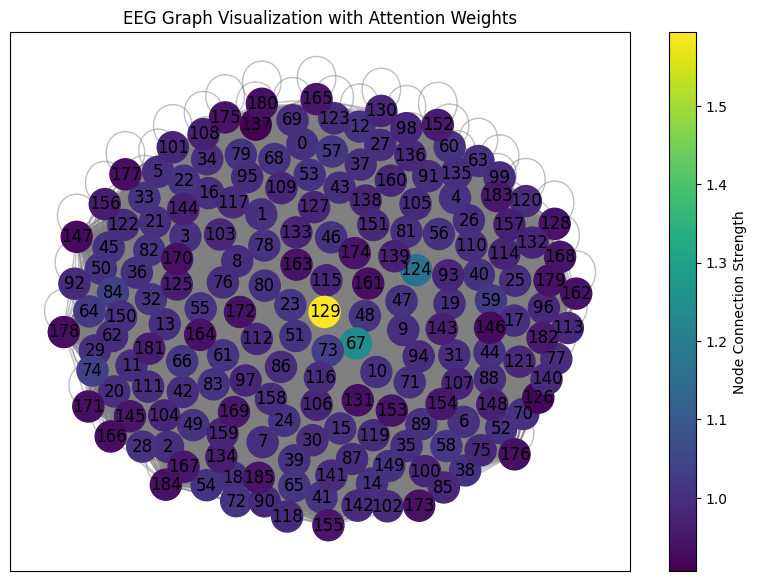

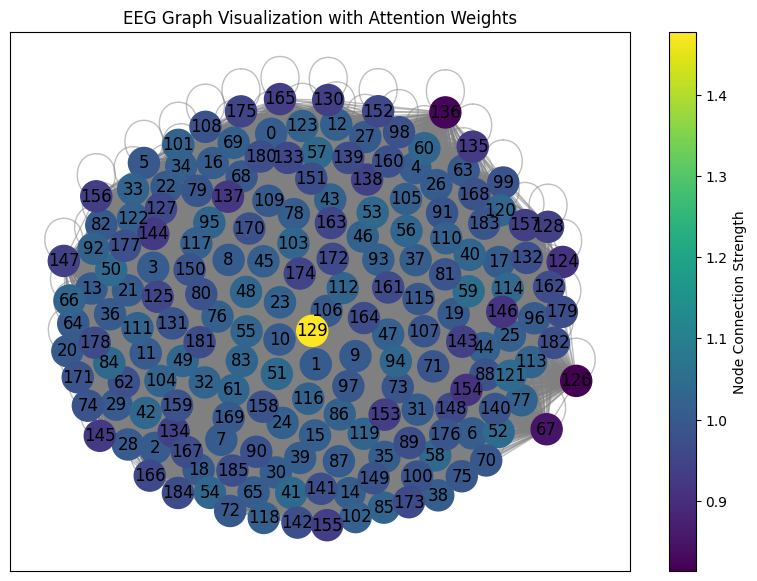

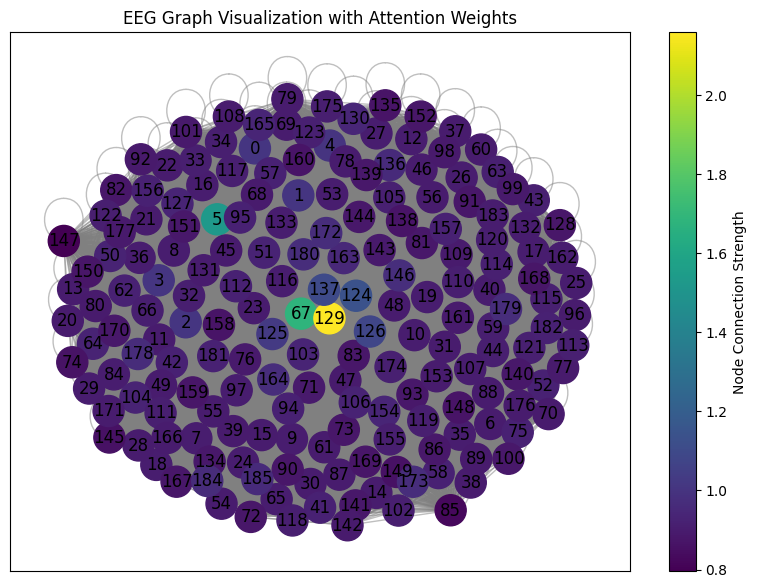

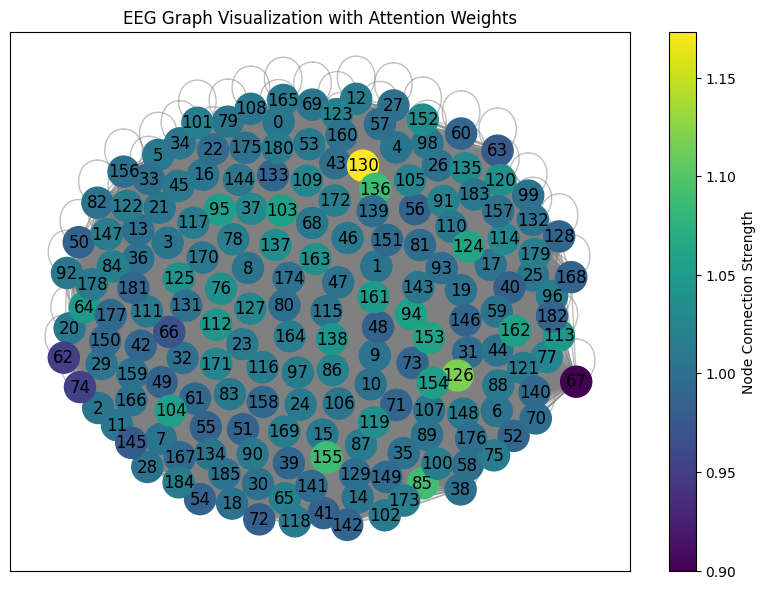

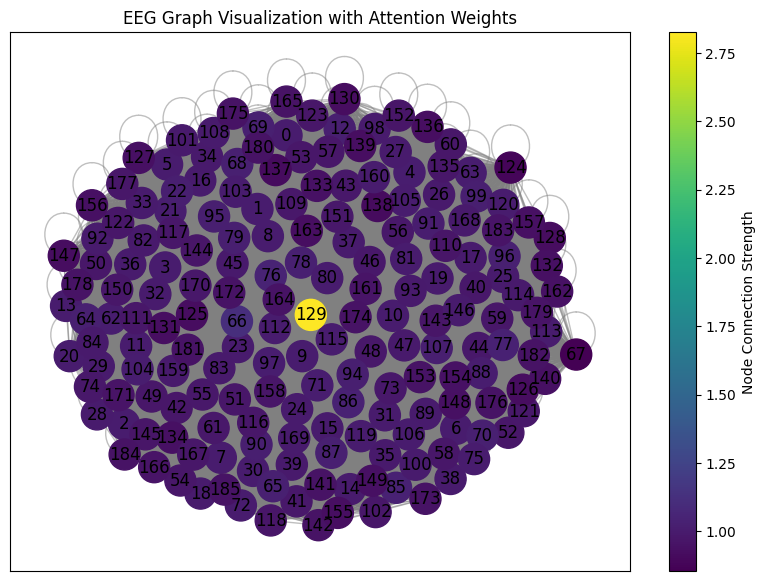

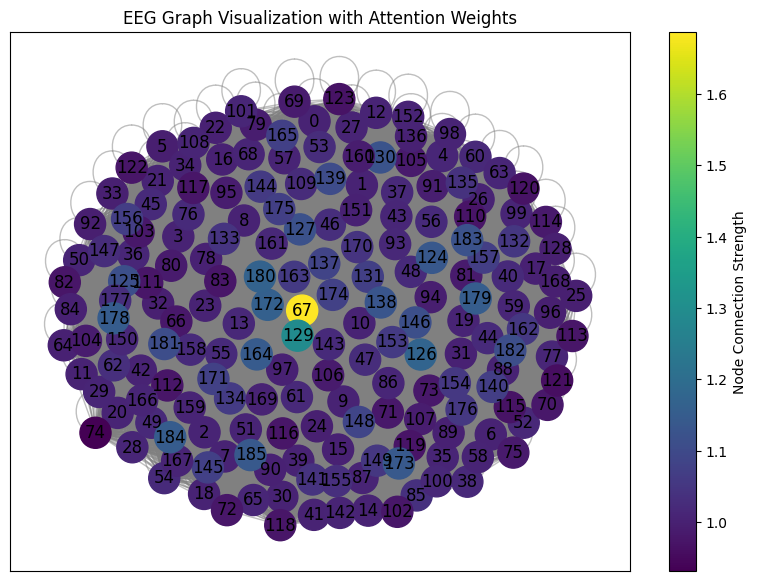

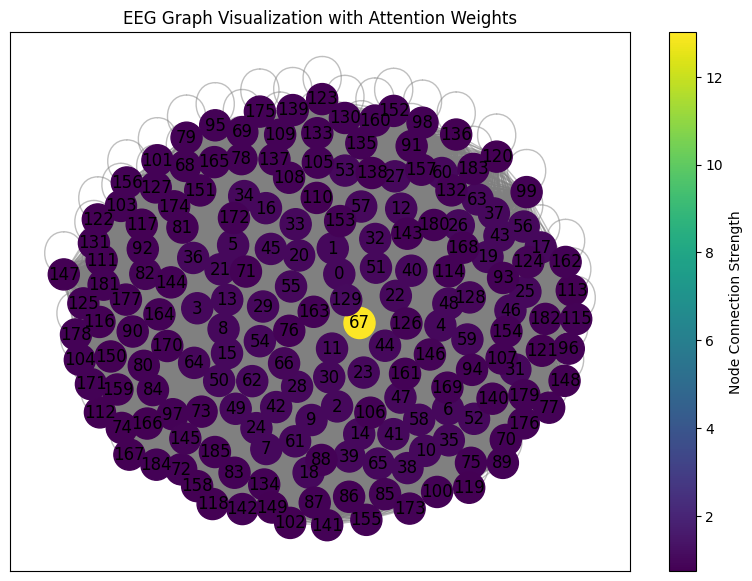

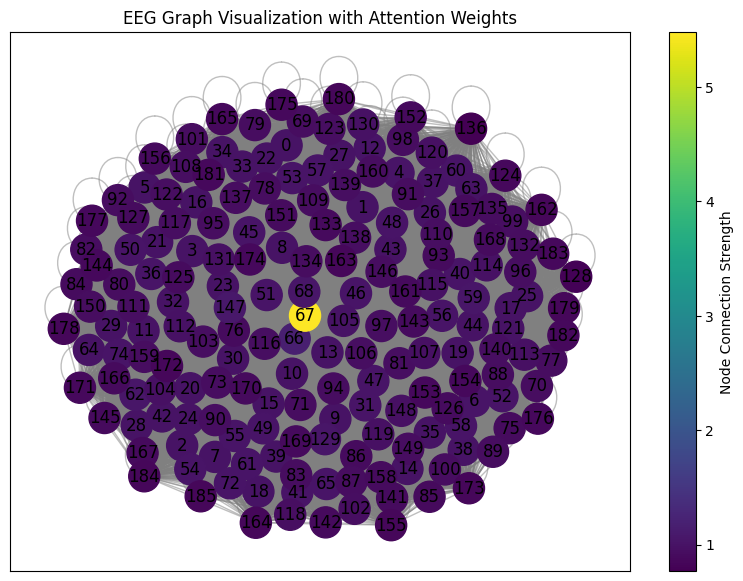

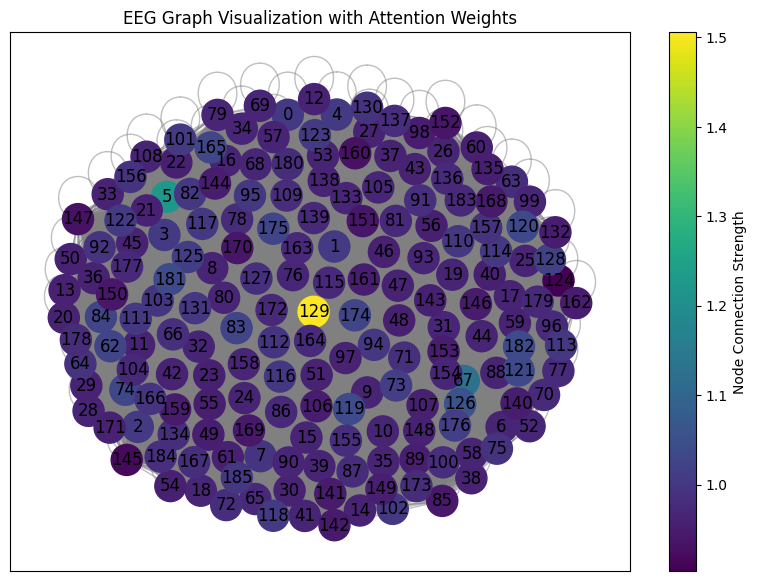

In [5]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

for n in range(10):
# 加载注意力权重和 edge_index
    attention_weights = torch.load(f'/data/Anaiis/garage/vis_data/7_20131030/attn_weight_l1theta_{n}.pt')
    edge_index = torch.load(f'/data/Anaiis/garage/vis_data/7_20131030/edge_index_l1theta_{n}.pt')
    label = torch.load(f'/data/Anaiis/garage/vis_data/7_20131030/labels_{n}.pt').item()

    # 将 edge_index 和 attention_weights 转换为 NumPy 数组
    edge_index_np = edge_index.cpu().numpy()
    attention_weights_np = attention_weights.cpu().numpy().squeeze()

    # 计算每个边的平均注意力权重（如果有多个头部）
    attention_weights_np = attention_weights_np.mean(axis=1)

    # 创建一个无向图
    G = nx.Graph()

    # 假设节点编号从0开始连续编号
    num_nodes = edge_index.max().item() + 1
    G.add_nodes_from(range(num_nodes))

    # 添加边及其权重
    for i in range(edge_index_np.shape[1]):
        src = edge_index_np[0, i]
        dst = edge_index_np[1, i]
        weight = attention_weights_np[i]
        G.add_edge(src, dst, weight=weight)

    # 计算每个节点的总连接强度（即所有相连边的权重之和）
    node_strength = {node: 0.0 for node in G.nodes()}
    for (u, v, d) in G.edges(data=True):
        node_strength[u] += d['weight']
        node_strength[v] += d['weight']

    # 固定节点位置
    pos = nx.spring_layout(G, seed=42)  # 固定布局

    # 将节点强度转换为颜色值（归一化到 [0, 1]）
    node_colors = np.array(list(node_strength.values()))
    node_colors_normalized = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())
    cmap = plt.cm.viridis

    # 绘制图形
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors_normalized, node_size=500, cmap=cmap)
    weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=1, edge_color='grey', alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=node_colors.min(), vmax=node_colors.max()))
    sm.set_array([])
    plt.colorbar(sm, label='Node Connection Strength')

    plt.title('EEG Graph Visualization with Attention Weights')
    # plt.show()
    plt.savefig(f'/data/Anaiis/garage/figs/seed_label{label}/7_20131030/theta_fig_{n}')
    


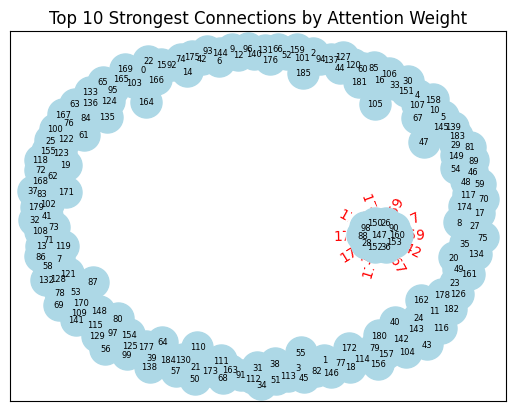

In [28]:
# 获取前10个最大权重的边索引
top_k = 10
top_indices = attention_weights_np.argsort()[-top_k:][::-1]  # 从大到小排序

top_edges = [(edge_index_np[0, i], edge_index_np[1, i]) for i in top_indices]
top_weights = [attention_weights_np[i] for i in top_indices]

# 创建一个新的图，仅包含前10条边
G_top = nx.Graph()
G_top.add_nodes_from(range(edge_index.max().item() + 1))
for (src, dst), weight in zip(top_edges, top_weights):
    G_top.add_edge(src, dst, weight=weight)

# 生成节点的布局
pos = nx.spring_layout(G_top)

# 绘制节点
nx.draw_networkx_nodes(G_top, pos, node_color='lightblue', node_size=500)

# 绘制带有颜色和宽度的边
edge_widths = [weight * 5 for weight in top_weights]
edge_colors = [plt.cm.Blues((weight - min(top_weights)) / (max(top_weights) - min(top_weights))) for weight in top_weights]
nx.draw_networkx_edges(G_top, pos, width=edge_widths, edge_color=edge_colors)

# 绘制边的权重标签
edge_labels = {(src, dst): f'{weight*10000:.4f}' for (src, dst), weight in zip(top_edges, top_weights)}
nx.draw_networkx_edge_labels(G_top, pos, edge_labels=edge_labels, font_color='red')

# 绘制节点标签
nx.draw_networkx_labels(G_top, pos, font_size=6, font_color='black')

plt.title("Top 10 Strongest Connections by Attention Weight")
plt.show()

In [32]:
len(set(attention_weights_np))

34527

In [34]:
(attention_weights.shape)

torch.Size([34596, 1])

上一part结论：attn weight拉不开差距，要不显示特征试试？头皮图

In [21]:
for i in range(20, 30):
    attn_weight = torch.load(f'./vis_data/afterconv_de_{i}.pt')
    print("true label:", torch.load(f'./vis_data/labels_{i}.pt').item())
    attn_weight[:, 0].shape
    feat0 =  attn_weight[:, 0]
    # feat0.reshape((62, 3))
    print("feat0", feat0.unique())
    print("feat1", attn_weight[:, 1].unique())
    print("feat2", attn_weight[:, 2].unique())

true label: 2
feat0 tensor([11.6312, 11.6312, 11.6312, 11.6312, 11.6312, 11.6312, 11.6312, 11.6312,
        11.6312, 11.6312, 11.6312, 11.6312, 11.6312], device='cuda:1')
feat1 tensor([2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715, 2.6715],
       device='cuda:1')
feat2 tensor([48.7491, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492,
        48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492, 48.7492,
        48.7492], device='cuda:1')
true label: 1
feat0 tensor([-0.0022, -0.0022, -0.0022, -0.0022, -0.0022, -0.0022, -0.0022, -0.0022,
        -0.0022, -0.0022], device='cuda:1')
feat1 tensor([20.0898, 20.0898, 20.0898, 20.0898, 20.0898, 20.0898, 20.0898, 20.0898,
        20.0899, 20.0899], device='cuda:1')
feat2 tensor([0.2720, 0.2720, 0.2720, 0.2720, 0.2720, 0.2720, 0.2720, 0.2720],
       device='cuda:1')
true label: 2
feat0 tensor([2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551, 2.4551],
       device='cuda:1')
feat1 tensor([6

两次图卷积后的特征收敛到一个数值周围，所有节点都在这个数周围（单看每张图，三个标签收敛到的数值有巨大差异，很容易分类），但是是什么时候收敛到的呢，什么导致了这个收敛呢？

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# 假设你有三个时刻的数据，每个时刻有62个通道，通道编号从0到185
# 这里我们用随机数据来模拟你的EEG特征数据（假设特征已经聚合成一个标量值）
n_channels = 62
n_times = 3

# 模拟三个时刻的EEG数据，每个通道一个标量值
# 这里的`data`数组应替换为你实际的EEG数据，维度为 (n_times, n_channels)
data = np.random.rand(n_times, n_channels)

# 使用MNE的标准电极位置（10-20系统）
montage = mne.channels.make_standard_montage('standard_1020')

# 创建一个Info对象来描述EEG信号的相关信息
info = mne.create_info(ch_names=montage.ch_names[:n_channels], sfreq=256, ch_types='eeg')

# 将电极信息添加到Info对象中
info.set_montage(montage)

# 绘制每个时刻的拓扑图
fig, axes = plt.subplots(1, n_times, figsize=(15, 5))

for i in range(n_times):
    mne.viz.plot_topomap(data[i], pos=montage.get_positions()['ch_pos'], axes=axes[i], show=False)
    axes[i].set_title(f'Time point {i+1}')

plt.show()
